In [12]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [13]:
DATA_DIR = Path('data')

color_pal = sns.color_palette('Set1')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Explore metadata.csv

In [4]:
metadata = pd.read_csv(DATA_DIR / 'metadata.csv')
metadata

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


In [53]:
(metadata['latitude'].astype(str) + ',' + metadata['longitude'].astype(str)).nunique()

12681

In [5]:
metadata['split'].value_counts()

train    17060
test      6510
Name: split, dtype: int64

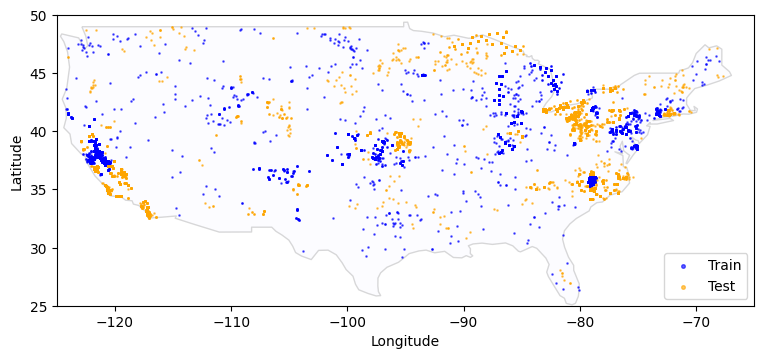

In [6]:
fig, ax = plt.subplots(figsize=(9, 4))

base = world[world.name == "United States of America"].plot(
    edgecolor='gray',
    color='ghostwhite',
    figsize=(9, 4),
    alpha=0.3,
    ax=ax
)

train_metadata = metadata[metadata['split'] == 'train']
geometry = [Point(xy) for xy in zip(train_metadata['longitude'], train_metadata['latitude'])]
gdf = gpd.GeoDataFrame(train_metadata, geometry=geometry)
gdf.plot(
    ax=base,
    marker='.',
    markersize=3,
    color='blue',
    label='Train',
    alpha=0.6
)

test_metadata = metadata[metadata['split'] == 'test']
geometry = [Point(xy) for xy in zip(test_metadata['longitude'], test_metadata['latitude'])]
gdf = gpd.GeoDataFrame(test_metadata, geometry=geometry)
gdf.plot(
    ax=base,
    marker='.',
    markersize=3,
    color='orange',
    label='Test',
    alpha=0.6
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

In [7]:
metadata.date = pd.to_datetime(metadata.date)

metadata.groupby('split').agg(min_date=('date', 'min'), max_date=('date', 'max'))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


<AxesSubplot: title={'center': 'Distribution of years in the data'}, xlabel='Year', ylabel='Number of samples'>

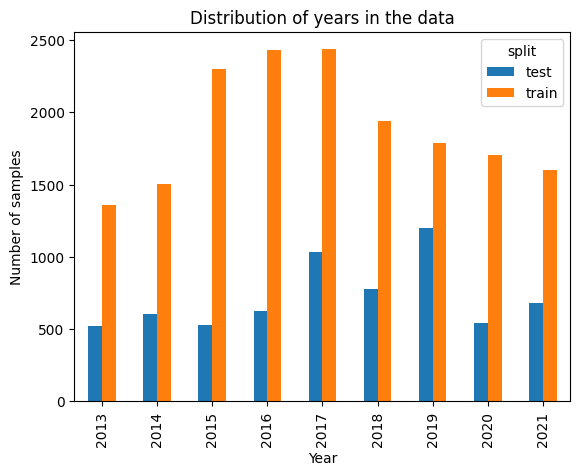

In [8]:
pd.crosstab(metadata.date.dt.year, metadata.split).plot(
    kind='bar',
    ylabel='Number of samples',
    xlabel='Year',
    title='Distribution of years in the data'
)

In [9]:
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

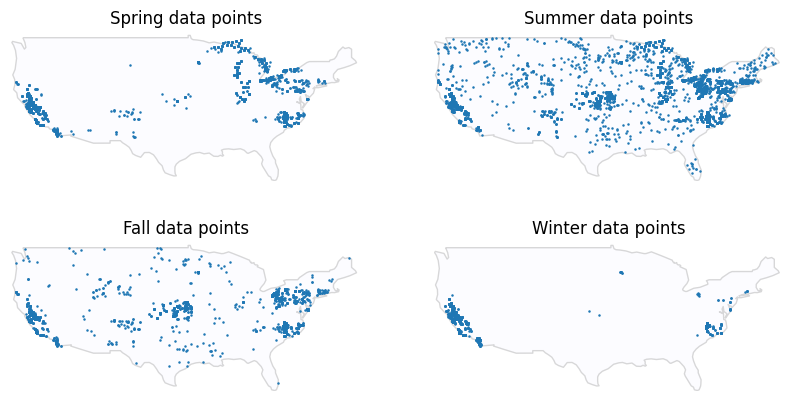

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor='gray',
        color='ghostwhite',
        alpha=0.3,
        ax=ax
    )
    
    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub['longitude'], sub['latitude'])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(
        ax=base,
        marker='.',
        markersize=2.5
    )
    
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## Explore train_labels.csv

In [11]:
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')
train_labels

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0
...,...,...,...,...
17055,zzsv,south,3,113125.0
17056,zzuq,south,3,175726.0
17057,zzwo,midwest,2,48510.0
17058,zzwq,south,1,1271.0


In [12]:
train_labels.shape

(17060, 4)

In [13]:
train_labels_and_metadata = train_labels.merge(
    metadata,
    how='left',
    left_on='uid',
    right_on='uid',
    validate='1:1'
)

In [14]:
train_labels_and_metadata

,uid,region,severity,density,latitude,longitude,date,split,season
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,spring
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,fall
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,summer
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,summer
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,summer
...,...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train,summer
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train,summer
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train,summer
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train,spring


Text(0.5, 1.0, 'Train labels severity level counts')

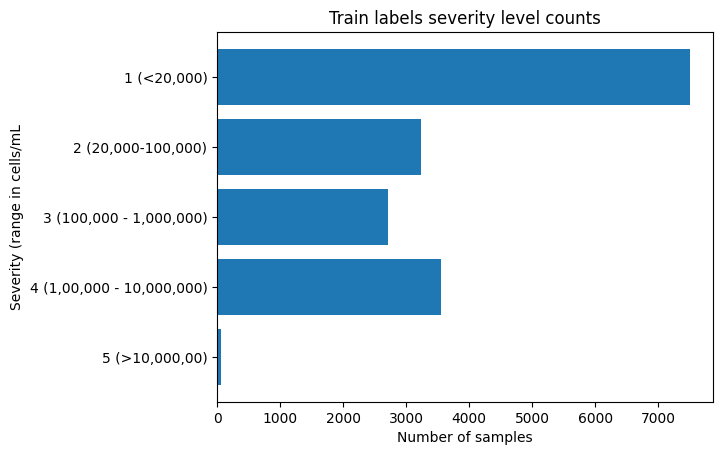

In [15]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    ).severity.value_counts().sort_index(ascending=False)
)

plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL")
plt.title("Train labels severity level counts")

In [16]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [17]:
(train_labels.density == 0).sum()

91

## Explore submission_format.csv

In [18]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv')
submission_format

,uid,region,severity
0,aabn,west,1
1,aair,west,1
2,aajw,northeast,1
3,aalr,midwest,1
4,aalw,west,1
...,...,...,...
6505,zzpn,northeast,1
6506,zzrv,west,1
6507,zzsx,south,1
6508,zzvv,west,1


In [19]:
submission_format.shape

(6510, 3)

## External Data

##### The general steps we'll use to pull satellite data are:
1. Establish a connection to the Planetary Computer's STAC API using the planetary_computer and pystac_client Python packages.

2. Query the STAC API for scenes that capture our in situ labels. For each sample, we'll search for imagery that includes the sample's location (latitude and longitude) around the date the sample was taken. In this benchmark, we'll use only Sentinel-2 L2A and Landsat Level-2 data.

3. Select one image for each sample. We'll use Sentinel-2 data wherever it is available, because it is higher resolution. We'll have to use Landsat for data before roughly 2016, because Sentinel-2 was not available yet.

4. Convert the image to a 1-dimensional list of features that can be input into our tree model


In [20]:
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [21]:
example_row = metadata[metadata.uid == 'garm'].iloc[0]
example_row

uid                         garm
latitude                41.98006
longitude             -110.65734
date         2021-09-27 00:00:00
split                      train
season                      fall
Name: 5461, dtype: object

In [22]:
import geopy.distance as distance

In [23]:
def get_bounding_box(latitute, longitude, meter_buffer=50000):
    distance_search = distance.distance(meters=meter_buffer)
    
    min_lat = distance_search.destination(point=(latitute, longitude), bearing=180).latitude
    min_long = distance_search.destination(point=(latitute, longitude), bearing=270).longitude
    max_lat = distance_search.destination(point=(latitute, longitude), bearing=0).latitude
    max_long = distance_search.destination(point=(latitute, longitude), bearing=90).longitude
    
    return [min_long, min_lat, max_long, max_lat]

bbox = get_bounding_box(example_row.latitude, example_row.longitude)
bbox


[-111.26063646639783,
 41.52988747516146,
 -110.05404353360218,
 42.43019710235757]

In [24]:
def get_date_range(date, time_buffer_days=15):
    
    datetime_format = '%Y-%m-%d'
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    #date_range = f"{range_start.strftime(datetime_format)}T00:00:00Z/{pd.to_datetime(date).strftime(datetime_format)}T00:00:00Z"
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range

date_range = get_date_range(example_row.date)
date_range

'2021-09-12/2021-09-27'

In [25]:
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"],
    bbox=bbox,
    datetime=date_range
)

items = [item for item in search.get_all_items()]
len(items)

46

In [26]:
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

In [27]:
item_details['contains_sample_point'] = (
    (item_details.min_lat < example_row.latitude)
    & (example_row.latitude < item_details.max_lat)
    & (item_details.min_long < example_row.longitude)
    & (example_row.longitude < item_details.max_long)
)

In [28]:
item_details = item_details[item_details['contains_sample_point']]
item_details[['datetime', 'platform', 'contains_sample_point', 'bbox']].sort_values(by='datetime')

,datetime,platform,contains_sample_point,bbox
44,2021-09-12,landsat-8,True,"[-111.34023745, 40.67702495, -108.51528663, 42..."
34,2021-09-14,Sentinel-2A,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
21,2021-09-19,Sentinel-2B,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
26,2021-09-19,landsat-8,True,"[-112.92522743, 40.67353498, -110.06644659, 42..."
18,2021-09-20,landsat-7,True,"[-111.60018779, 40.80284495, -108.59831681, 42..."
8,2021-09-24,Sentinel-2A,True,"[-111.000244, 41.4562419, -109.665115, 42.4526..."
5,2021-09-27,landsat-7,True,"[-113.18385774, 40.78803499, -110.15150674, 42..."


### Inspect Sentinel Imagery

In [29]:
item_details[item_details.platform.str.contains('Sentinel')]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
8,2021-09-24,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.4562419, -109.665115, 42.4526...",<Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...,True
21,2021-09-19,Sentinel-2B,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2B_MSIL2A_20210919T180919_R084_T12TW...,True
34,2021-09-14,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2A_MSIL2A_20210914T180951_R084_T12TW...,True


In [30]:
best_item = (
    item_details[item_details.platform.str.contains('Sentinel')]
    .sort_values(by='datetime', ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-24
platform                                                       Sentinel-2A
min_long                                                       -111.000244
max_long                                                       -109.665115
min_lat                                                          41.456242
max_lat                                                          42.452691
bbox                     [-111.000244, 41.4562419, -109.665115, 42.4526...
item_obj                 <Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...
contains_sample_point                                                 True
Name: 8, dtype: object

In [31]:
item = best_item.item_obj

In [32]:
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [33]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [34]:
img = Image(url=item.assets['rendered_preview'].href, width=500)

display(img)

In [35]:
def crop_sentinel_image(item, bounding_box):
    
    (minx, miny, maxx, maxy) = bounding_box
    
    image = rioxarray.open_rasterio(pc.sign(item.assets['visual'].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs='EPSG:4326'
    )
    return image.to_numpy()

In [36]:
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

bbox = (minx, miny, maxx, maxy)
zoomed_image = crop_sentinel_image(item, bbox)

zoomed_image[0]

array([[214, 224, 213, ..., 124, 109, 103],
       [215, 220, 201, ..., 114,  95,  94],
       [217, 222, 187, ..., 106,  95,  94],
       ...,
       [223, 185, 193, ..., 112, 118, 120],
       [181, 140, 190, ..., 110, 111, 117],
       [134, 125, 185, ..., 107, 107, 111]], dtype=uint8)

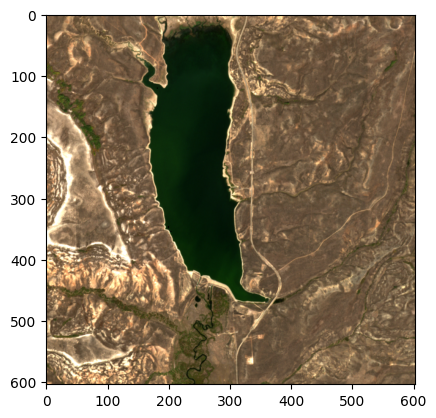

In [37]:
plt.imshow(np.transpose(zoomed_image, axes=[1, 2, 0]))

### Inspect Landsat imagery

In [38]:
import odc.stac
import cv2

In [39]:
landsat_item = (
    item_details[item_details.platform.str.contains('landsat')]
    .sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item

datetime                                                        2021-09-12
platform                                                         landsat-8
min_long                                                       -111.340237
max_long                                                       -108.515287
min_lat                                                          40.677025
max_lat                                                          42.817595
bbox                     [-111.34023745, 40.67702495, -108.51528663, 42...
item_obj                         <Item id=LC08_L2SP_037031_20210912_02_T1>
contains_sample_point                                                 True
Name: 44, dtype: object

In [40]:
def crop_landsat_image(item, bounding_box):
    
    (minx, miny, maxx, maxy) = bounding_box
    
    image = odc.stac.stac_load(
        [pc.sign(item)],
        bands=['red', 'green', 'blue'],
        bbox=[minx, miny, maxx, maxy],
    ).isel(time=0)
    
    image_array = image[['red', 'green', 'blue']].to_array().to_numpy()
    
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)
    
    return image_array

In [41]:
item = landsat_item.item_obj

landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]

array([[104, 108,  94, ...,  85,  86,  88],
       [106, 110,  95, ...,  86,  89,  87],
       [106, 105,  94, ...,  89,  89,  85],
       ...,
       [106, 100,  96, ...,  90,  89,  90],
       [ 95,  93,  92, ...,  89,  88,  88],
       [113, 105, 103, ...,  88,  87,  89]], dtype=uint16)

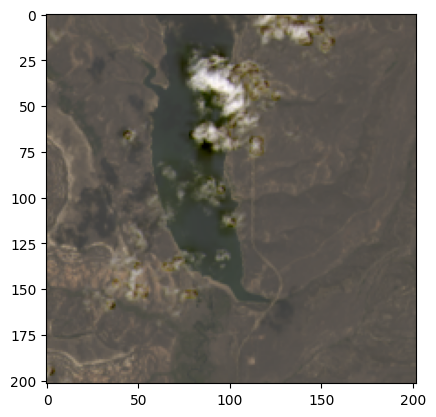

In [42]:
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

### Convert imagery to features

In [43]:
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=100
)
minx, miny, maxx, maxy

(-110.65854661288282,
 41.97915969028358,
 -110.6561333871172,
 41.980960309574755)

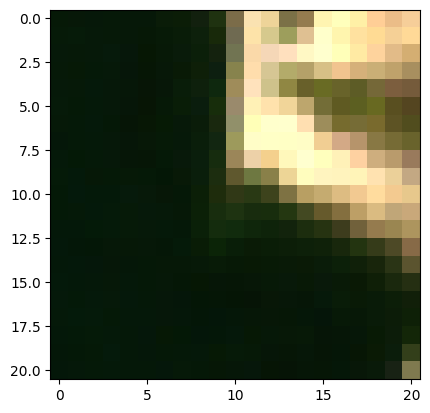

In [44]:
bbox = (minx, miny, maxx, maxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=bbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))

In [45]:
type(feature_image_array), feature_image_array.shape

(numpy.ndarray, (3, 21, 21))

In [46]:
imagee_color_averages = feature_image_array.mean(axis=(1, 2)).tolist()

image_color_medians = np.median(feature_image_array, axis=(1, 2)).tolist()

image_features = imagee_color_averages + image_color_medians
image_features

[64.1156462585034, 71.21541950113378, 42.44897959183673, 8.0, 26.0, 9.0]

## Refactor and Run

In [47]:
def select_best_item(items, date, latitude, longitude):
    # get item details
    item_details = pd.DataFrame(
        [
            {
                'datetime': item.datetime.strftime("%Y-%m-%d"),
                'platform': item.properties['platform'],
                'min_long': item.bbox[0],
                'max_long': item.bbox[2],
                'min_lat': item.bbox[1],
                'max_lat': item.bbox[3],
                'item_obj': item,
            }
            for item in items
        ]
    )
    
    # filter to items that contain the point location, return None if none contain the point
    item_details['contains_sample_point'] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details['contains_sample_point'] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)
    
    # add time difference between each item and the sample date
    item_details['time_diff'] = pd.to_datetime(date) - pd.to_datetime(item_details.datetime)
    
    # if we have sentinel-2, filter to sentinel-2 only
    item_details['sentinel'] = item_details.platform.str.lower().str.contains('sentinel')
    if item_details['sentinel'].any():
        item_details = item_details[item_details['sentinel'] == True]
        
    # return the closest imagery by time
    best_item = item_details.sort_values(by='time_diff', ascending=True).iloc[0]
    
    return (best_item.item_obj, best_item.platform, best_item.datetime)

In [48]:
def image_to_features(image_array):
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()
    
    return averages + medians

In [14]:
BENCHMARK_DATA_DIR = DATA_DIR / 'benchmark'

IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / 'image_arrays'
IMAGE_ARRAY_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
train_subset = metadata[metadata['split'] == 'train'].sample(n=2500, random_state=2)

metadata_subset = pd.concat([train_subset, metadata[metadata['split'] == 'test']])
metadata_subset.split.value_counts(dropna=False)